In [1]:
import pandas as pd
from google.colab import files
import io
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [2]:
uploaded = files.upload()

Saving news.csv to news.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['news.csv']))

In [4]:
print(df.columns)
df["label"].replace({"REAL": 1, "FAKE": 0}, inplace=True)
y = df.iloc[:, -1]
df["new_text"] = df["title"] + df["text"]
X = df.iloc[:, -1]
print(y.value_counts(normalize=True))
X = np.array(X)
y = np.array(y)
#print(X)
#print(y)

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')
1    0.500552
0    0.499448
Name: label, dtype: float64


In [5]:
def length_dicsarding_space(text):
    return len(text) - text.count(' ')

(array([999., 994., 925., 789., 750., 520., 384., 305., 195.,  92.,  79.,
         48.,  43.,  37.,  19.,  25.,  14.,  18.,  10.,  16.,   7.,   9.,
         12.,   8.,   7.,   1.,   2.,   2.,   1.,   4.,   1.,   1.,   0.,
          2.,   1.,   1.,   4.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]), array([1.000000e+01, 9.552900e+02, 1.900580e+03, 2.845870e+03,
        3.791160e+03, 4.736450e+03, 5.681740e+03, 6.627030e+03,
        7.572320e+03, 8.517610e+03, 9.462900e+03, 1.040819e+04,
        1.135348e+04, 1.229877e+04, 1.324406e+04, 1.418935e+04,
        1.513464e+04, 1.607993e+04, 1.702522e+04, 1.797051e+04,

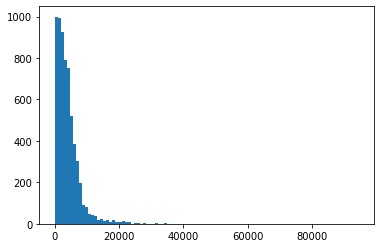

In [6]:
text_lengths = []
for i in X:
    text_lengths.append(len(i) - i.count(' '))

plt.hist(text_lengths, bins=100)

In [7]:
max_features = 10000
#sequence_length = max(list(map(length_dicsarding_space, X)))
sequence_length = 25000
print(sequence_length)

25000


In [8]:
vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [9]:
vectorize_layer.adapt(X)

print(vectorize_layer(X[0]))

tf.Tensor([  39   64 8936 ...    0    0    0], shape=(25000,), dtype=int64)


In [10]:
vectorized_text = vectorize_layer(X)
#print(vectorized_text)
vectorized_text = np.array(vectorized_text)
print(vectorized_text.shape)

(6335, 25000)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_text, y, test_size=.33, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.33, random_state=42)

In [12]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4244, 25000)
(1400, 25000)
(691, 25000)
(4244,)
(1400,)
(691,)


In [13]:
embedding_dim = 16

In [14]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

In [15]:
model.compile(loss=tf.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy())

In [16]:
epochs = 100
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs)

Epoch 1/100
133/133 [==============================] - 29s 210ms/step - loss: 1.4872 - binary_accuracy: 0.5014 - val_loss: 0.9324 - val_binary_accuracy: 0.4921
Epoch 2/100
133/133 [==============================] - 28s 207ms/step - loss: 0.8339 - binary_accuracy: 0.5014 - val_loss: 0.7622 - val_binary_accuracy: 0.4921
Epoch 3/100
133/133 [==============================] - 28s 214ms/step - loss: 0.7294 - binary_accuracy: 0.4988 - val_loss: 0.7030 - val_binary_accuracy: 0.4921
Epoch 4/100
133/133 [==============================] - 28s 208ms/step - loss: 0.7055 - binary_accuracy: 0.5026 - val_loss: 0.6938 - val_binary_accuracy: 0.4921
Epoch 5/100
133/133 [==============================] - 28s 208ms/step - loss: 0.6989 - binary_accuracy: 0.5104 - val_loss: 0.6923 - val_binary_accuracy: 0.4921
Epoch 6/100
133/133 [==============================] - 28s 207ms/step - loss: 0.6965 - binary_accuracy: 0.5106 - val_loss: 0.6911 - val_binary_accuracy: 0.4921
Epoch 7/100
133/133 [===================

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print(loss)
print(accuracy)

22/22 [==============================] - 1s 23ms/step - loss: 0.3413 - binary_accuracy: 0.8524
0.34134984016418457
0.8523878455162048


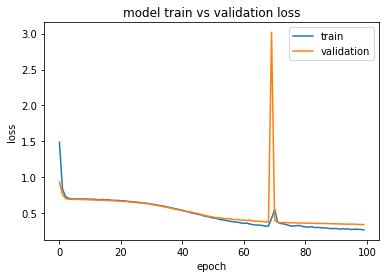

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

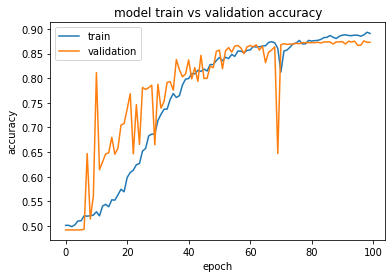

In [19]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [20]:
threshold = 0.5
y_pred = model.predict(X_test) 
y_pred05 = np.where(y_pred > threshold, 1,0)

22/22 [==============================] - 1s 24ms/step


In [21]:
confusion_matrix(y_test, y_pred05)

array([[326,  21],
       [ 81, 263]])

In [22]:
accuracy_score(y_test, y_pred05)

0.8523878437047757

In [23]:
f1_score(y_test, y_pred05)

0.8375796178343949

In [33]:
threshold = 0.35
y_pred04 = np.where(y_pred > threshold, 1,0)

In [34]:
confusion_matrix(y_test, y_pred04)

array([[305,  42],
       [ 37, 307]])

In [35]:
accuracy_score(y_test, y_pred04)

0.8856729377713459

In [36]:
f1_score(y_test, y_pred04)

0.886002886002886

In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred05).ravel()

In [29]:
print(fn)

81


In [30]:
fn_indices = [i for i, (x, y) in enumerate(zip(y_test, y_pred05)) if x == 1 and y == 0]
fp_indices = [i for i, (x, y) in enumerate(zip(y_test, y_pred05)) if x == 0 and y == 1]
tp_indices = [i for i, (x, y) in enumerate(zip(y_test, y_pred05)) if x == 1 and y == 1]
tn_indices = [i for i, (x, y) in enumerate(zip(y_test, y_pred05)) if x == 0 and y == 0]

In [31]:
print(len(fn_indices))
print(len(fp_indices))
print(len(tp_indices))
print(len(tn_indices))

81
21
263
326


In [38]:
print(X_test[fn_indices])

[[   2  352 1314 ...    0    0    0]
 [1199   53    1 ...    0    0    0]
 [ 182  949 1196 ...    0    0    0]
 ...
 [ 184   17  321 ...    0    0    0]
 [ 797  136    2 ...    0    0    0]
 [ 127   29    6 ...    0    0    0]]


In [32]:
fn_zeros = np.count_nonzero(X_test[fn_indices]==0, axis=1)
fp_zeros = np.count_nonzero(X_test[fp_indices]==0, axis=1)
tp_zeros = np.count_nonzero(X_test[tp_indices]==0, axis=1)
tn_zeros = np.count_nonzero(X_test[tn_indices]==0, axis=1)
print(fn_zeros)
print(fp_zeros)
print(tp_zeros)
print(tn_zeros)

[24398 24756 24975 24234 23780 24638 24969 24977 24292 24393 24973 24880
 24896 24619 24743 24785 24983 23927 24595 24658 24773 24977 23947 24892
 23306 24240 24395 24480 23938 24978 24975 24938 24979 24922 24104 24977
 24933 24980 24710 24857 24924 24978 24969 24968 24923 24520 24985 24915
 24200 24645 24395 24445 24640 23670 23860 24307 24204 24340 24903 24905
 24931 24869 24979 24976 24797 24972 24889 24862 24628 24945 24926 23573
 24241 24209 24406 24979 24980 24985 24812 24984 23804]
[23700 24720 24423 24695 24636 23186 24317 24727 23974 24562 24674 24461
 24207 18243 24631 24281 24434 24738 24348 24544 22767]
[23975 23630 24423 23751 24108 23910 24817 24559 24150 24127 24002 24611
 24379 23726 24033 24247 24255 24632 24656 24497 24345 24435 24718 24512
 23963 24280 24002 24622 22884 24441 21801 24059 24577 20767 24393 22559
 24006 24349 22075 24672 24374 24300 23439 23956 24199 24326 23554 24054
 24814 24030 24412 24046 23123 23799 23781 24745 24345 23480 23953 24576
 24259 23765